<h1 style="text-align:center; font-size:30px;">
Predicting Match Outcomes in League of Legends Using Early-Game Statistics
</h1>

<p style="text-align:center; font-size:15px; color:black;">
<b>Project by:</b> Nathan Wong<br>
<b>Date:</b> December 30, 2025
</p>

<hr>


In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.ticker as mtick

<br>
<h2>Introduction 🎮 </h2>
<hr>
<p>
League of Legends is a competitive multiplayer online game in which two teams of five players
compete to destroy the opposing team's base. Matches are characterized by distinct phases,
with early-game performance often setting the trajectory for the remainder of the game.
</p>

<p>
In high-skill competitive play, small advantages gained during the first 10 minutes, such as
gold leads, objective control, and vision dominance, can significantly influence the probability
of winning. This makes early-game statistics a compelling source of predictive information.
</p>



<br>
<h2>Problem at Hand    📌 </h2>
<hr>
<p>
The objective of this project is to build a machine learning model capable of predicting the
outcome of a League of Legends match using team-level statistics collected after the first
10 minutes of gameplay.
</p>

<ul>
  <li><b>Input:</b> Early-game team statistics (economy, objectives, combat, vision)</li>
  <li><b>Output:</b> Binary outcome indicating whether the blue team won</li>
  <li><b>Task:</b> Supervised binary classification</li>
</ul>

<p>
By restricting the analysis to early-game data, the model aims to capture meaningful signals
without relying on information from later stages of the match.
</p>
<br>


<h2> Notebook Contents 📂</h2>
<hr>
<ol>
  <li>Data Inspection and Feature Overview</li>
  <li>Feature Engineering and Selection</li>
  <li>Exploratory Data Analysis (EDA)</li>
  <li>Data Preprocessing and Scaling</li>
  <li>Model Development and Interpretation/Insights</li>
  <li>Limitations and Future Work</li>
  <li>Conclusion</li>
</ol>
<br>

<h2>1. Data Inspection and Feature Overview  </h2>

<hr>

<p>
The dataset, sourced from Kaggle, contains detailed team-level statistics from thousands of
high-skill ranked League of Legends matches. All features are aggregated at the 10-minute mark,
capturing early-game performance indicators before the outcome of the match is decided.
</p>

<ul>
  <li><b>Match Outcome:</b> Binary indicator of whether the blue team won the match</li>
  <li><b>Combat Metrics:</b> Kills, deaths, assists, and first blood</li>
  <li><b>Objective Control:</b> Dragons, Rift Heralds, and towers destroyed</li>
  <li><b>Economic Metrics:</b> Total gold, gold per minute, and gold differentials</li>
  <li><b>Experience Metrics:</b> Total experience, average level, and experience differentials</li>
  <li><b>Vision Control:</b> Wards placed and wards destroyed</li>
  <li><b>Farming Metrics:</b> Minions killed, jungle minions killed, and CS per minute</li>
</ul>

<p>
The dataset contains no missing values and consists entirely of numerical features.
</p>
<br>

In [110]:
lol_df = pd.read_csv('high_diamond_ranked_10min.csv.zip')
lol_df.head(5)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [111]:
lol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

<br>
The dataset contains information from over 9,000 unique matches,
with 19 features recorded per team, resulting in a total of 38 team-level variables.
</p>
<br>

<br>
<h2>2. Feature Engineering and Selection </h2>

<hr>

<p>
To better align the feature space with the target variable <i>blueWins</i>, new columns were created to represent Blue–Red differences across symmetric team statistics. Since the dataset is framed from the perspective of whether the Blue team wins, these difference-based columns explicitly encode relative advantage by capturing both Blue and Red performance within a single variable. For example, differences in kills, objectives, vision, and farming directly indicate whether Blue is ahead or behind in a given aspect of the game, while simultaneously reflecting Red team performance in a concise and interpretable manner. 
</p>

<p>
After introducing difference-based features, columns whose information was already represented through stronger or more informative variables were removed. Secondary combat statistics such as assists and deaths were dropped because their effects are implicitly captured through kill differentials and overall gold advantage. Similarly, derived rate-based metrics such as CS per minute and gold per minute were excluded, as they are calculated from totals that are already incorporated into farming and gold difference features. 




<p><b>Dropped columns:</b> gameId, blueKills, redKills, blueTotalGold, redTotalGold, redGoldDiff, blueTotalExperience, redTotalExperience, blueExperienceDiff, redExperienceDiff, blueAssists, redAssists, blueDeaths, redDeaths, blueWardsPlaced, redWardsPlaced, blueWardsDestroyed, redWardsDestroyed, blueEliteMonsters, redEliteMonsters, blueDragons, redDragons, blueHeralds, redHeralds, blueTowersDestroyed, redTowersDestroyed, blueTotalMinionsKilled, redTotalMinionsKilled, blueTotalJungleMinionsKilled, redTotalJungleMinionsKilled, blueAvgLevel, redAvgLevel, blueCSPerMin, redCSPerMin, blueGoldPerMin, redGoldPerMin</p>
<br>








In [112]:
diff_pairs = {
    "killDiff": ("blueKills", "redKills"),
    "wardsPlacedDiff": ("blueWardsPlaced", "redWardsPlaced"),
    "wardsDestroyedDiff": ("blueWardsDestroyed", "redWardsDestroyed"),
    "avgLevelDiff": ("blueAvgLevel", "redAvgLevel"),
    "eliteMonsterDiff": ("blueEliteMonsters", "redEliteMonsters"),
    "dragonDiff": ("blueDragons", "redDragons"),
    "heraldDiff": ("blueHeralds", "redHeralds"),
    "towerDiff": ("blueTowersDestroyed", "redTowersDestroyed"),
    "totalMinionsDiff": ("blueTotalMinionsKilled", "redTotalMinionsKilled"),
    "totalJungleMinionDiff": ("blueTotalJungleMinionsKilled", "redTotalJungleMinionsKilled")
}

for new_col, (blue_col, red_col) in diff_pairs.items():
    lol_df[new_col] = lol_df[blue_col] - lol_df[red_col]

lol_df = lol_df.rename(columns={"blueGoldDiff": "goldDiff", "blueExperienceDiff": "expDiff"})

In [113]:
cols_to_drop = ['gameId', 'blueKills', 'redKills', 'redFirstBlood', 'blueTotalGold', 'redExperienceDiff', 'redGoldDiff', 'redTotalGold', 'blueAvgLevel', 'redAvgLevel', 'blueWardsPlaced', 'redWardsPlaced', 'blueWardsDestroyed', 'redWardsDestroyed', 'blueEliteMonsters', 'redEliteMonsters', 
                'blueDragons', 'redDragons', 'blueHeralds', 'redHeralds', 'blueTowersDestroyed', 'redTowersDestroyed','blueTotalMinionsKilled', 'redTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'redTotalJungleMinionsKilled',
                'blueTotalExperience', 'redTotalExperience', 'blueAssists', 'redAssists', 'blueDeaths', 'redDeaths', 'blueCSPerMin', 'redCSPerMin', 'blueGoldPerMin', 'redGoldPerMin']

In [114]:
lol_df.drop(columns = cols_to_drop, inplace = True)

In [115]:
lol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   blueWins               9879 non-null   int64  
 1   blueFirstBlood         9879 non-null   int64  
 2   goldDiff               9879 non-null   int64  
 3   expDiff                9879 non-null   int64  
 4   killDiff               9879 non-null   int64  
 5   wardsPlacedDiff        9879 non-null   int64  
 6   wardsDestroyedDiff     9879 non-null   int64  
 7   avgLevelDiff           9879 non-null   float64
 8   eliteMonsterDiff       9879 non-null   int64  
 9   dragonDiff             9879 non-null   int64  
 10  heraldDiff             9879 non-null   int64  
 11  towerDiff              9879 non-null   int64  
 12  totalMinionsDiff       9879 non-null   int64  
 13  totalJungleMinionDiff  9879 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 1.1 MB


<br>
<h2>3. Exploratory Data Analysis </h2>
<hr>

With the engineered dataset, exploratory data analysis is conducted to investigate relationships between early-game, difference-based features from the first ten minutes of play and match outcomes. The visualizations presented below evaluate how these features differ between wins and losses for the Blue team, providing insight into the early-game factors associated with match success.




<p style="font-size: 18px;"><b>Is there any redundancy within these features?</b></p>
<p>By examining a heatmap of all the columns in the dataframe, we can identify features that provide little to no information about the match outcome.</p>


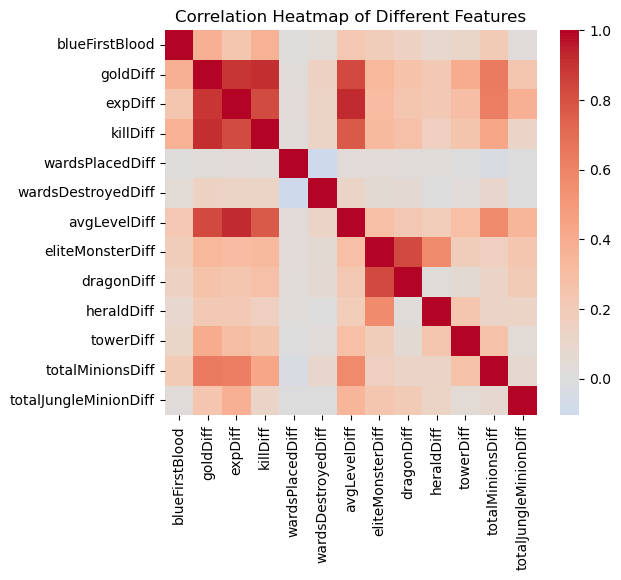

In [116]:
plt.figure(figsize=(6,5))
sb.heatmap(lol_df.drop(columns=["blueWins"]).corr(), cmap="coolwarm", center=0)
plt.title('Correlation Heatmap of Different Features')
plt.show()

<b><p style="font-size: 18px;"> Findings: </b>
<p>
The heatmap shows that the differences in gold, experience, and kills are very correlated, possibly indicating that advantages or disadvantages in these metrics affect each other directly.

Although vision control is an important strategic concept in League of Legends, early-game warding statistics did not show a meaningful relationship with match outcomes in this dataset. The distributions of both wards placed and wards destroyed were nearly identical for wins and losses, with substantial overlap and minimal differences in central tendency. This indicates that these features do not provide strong discriminatory power when predicting early-game victory.The impact of vision is often indirectly reflected through more outcome-driven features such as gold advantage, objective control, and kill differences. 

<p>
Additionally, differences in Gold and Experience captured the variation in Total Minions and Total Jungle Minions, rendering those features largely redundant. To reduce redundancy and improve model clarity, these features will be removed from the final dataset.
</p>
</p>

In [117]:
lol_df.drop(columns = ['wardsPlacedDiff', 'wardsDestroyedDiff', 'totalMinionsDiff', 'totalJungleMinionDiff'], inplace = True)

<br>
<p style="font-size: 18px;"><b>How related is each individual feature to blue wins?</b></p>

<p>
Below are categorical visualizations that illustrate the distribution of each engineered feature, grouped by match outcome. These visualizations help assess how strongly each feature is associated with blue team victories by comparing their values in wins versus losses.
</p>

<br>
<p style="font-size: 15px;"><b> Combat and Economy statistics</b></p>
<p> Boxplots are used to depict the correlation between these statistics and the outcome of the match.</p>

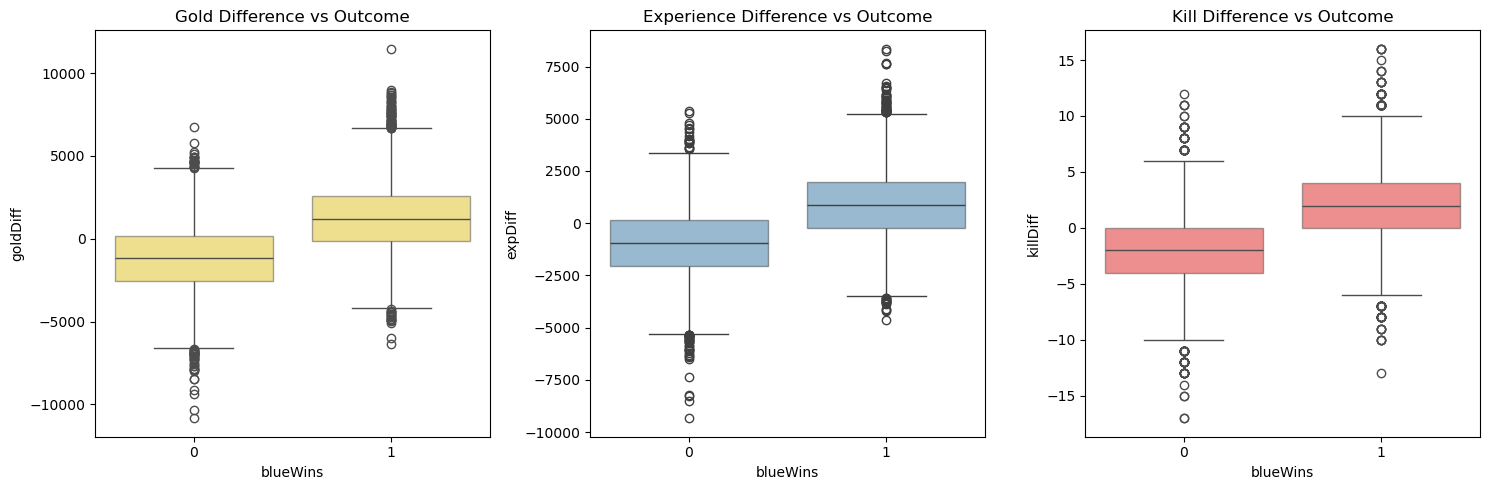

In [118]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sb.boxplot(x="blueWins", y="goldDiff", data=lol_df, ax=axes[0], color = 'gold', boxprops=dict(alpha=0.5))
axes[0].set_title("Gold Difference vs Outcome")

sb.boxplot(x="blueWins", y="expDiff", data=lol_df, ax=axes[1], boxprops=dict(alpha=0.5))
axes[1].set_title("Experience Difference vs Outcome")

sb.boxplot(x="blueWins", y="killDiff", data=lol_df, ax=axes[2], color = 'red',boxprops=dict(alpha=0.5))
axes[2].set_title("Kill Difference vs Outcome")

plt.tight_layout()
plt.show()

<br>
<p style="font-size: 15px;"><b> Objective Statistics</b></p>
<p> Violin plots are used to show the distribution of objective (dragons, heralds, towers) advantage, and how it relates to the outcome of the match</p>

In [119]:
long_df = lol_df.melt(id_vars="blueWins", value_vars=["dragonDiff", "heraldDiff", "towerDiff"],var_name="Objective", value_name="Difference")

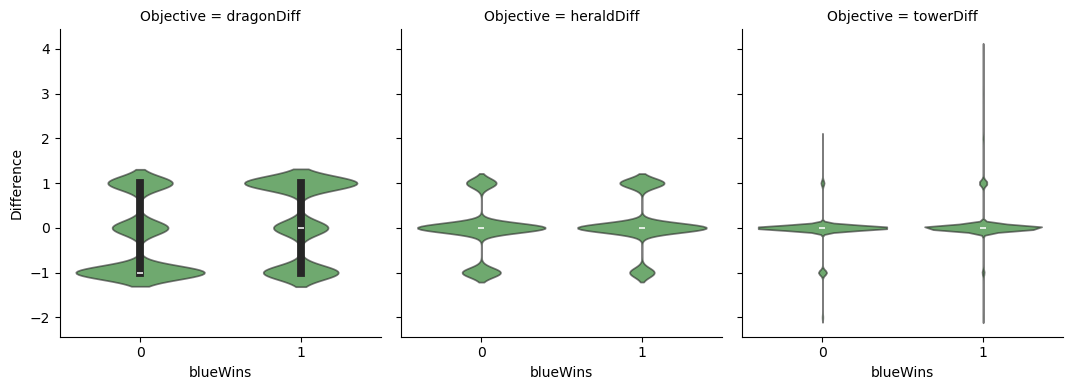

In [120]:
sb.catplot(data=long_df, x="blueWins", y="Difference", col="Objective", kind="violin", height=4, aspect=0.9, color = 'green', alpha = 0.6)
plt.show()


<br>
<b><p style="font-size: 18px;">Findings:</b> 
<p>
The box plots show that blue team victories are associated with positive differences in key metrics such as gold, kills, and experience, emphasizing the importance of early-game advantages in determining match outcomes.
</p>

<p>
The violin plots further highlight differences in early objective control between wins and losses. Dragon control exhibits the strongest relationship with match outcome, as victories are more frequently associated with positive dragon differences, indicating its substantial early-game impact.
</p>

<p>
By comparison, Rift Herald and tower differences show considerable overlap between wins and losses. This suggests that, within the first ten minutes, these objectives have a more situational or limited influence on match outcomes relative to dragons.
</p>

<br>

<br>
<p style="font-size: 18px;"><b>Does first blood matter?</b></p>
<p>
A bar plot is used to compare the win rates of matches in which the blue team secured first blood versus those in which it did not.
<br>
<br>

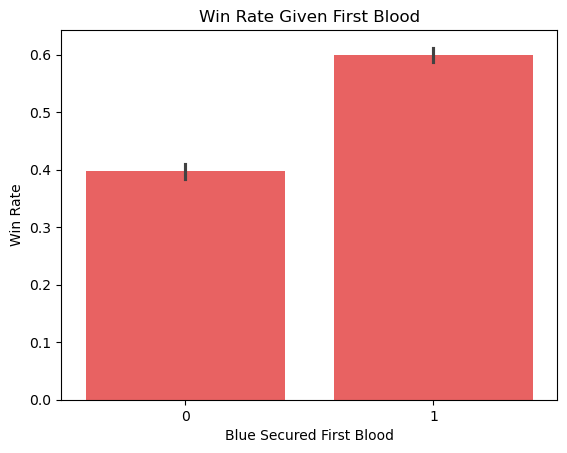

In [121]:
sb.barplot(x="blueFirstBlood", y="blueWins", data=lol_df, color = 'Red', alpha = 0.7)
plt.title("Win Rate Given First Blood")
plt.ylabel("Win Rate")
plt.xlabel("Blue Secured First Blood")
plt.show()

<br>
<b><p style="font-size: 18px;">Findings:</b> 
<p>
The bar plot reveals that blue team first bloods have a noticeable effect on the outcome of the match. This may be a result of obtaining early-game momentum, leading to dominance in other facets of the match.
<br>

<br>
<h2>4. Data Preprocessing and Scaling</h2>
<hr>


<p>
Since all engineered features are numerical and represent relative differences between teams, minimal preprocessing was required.
However, differences in certain features may be overrepresented during model training due to large disparities in their numerical ranges. For example, gold difference can span values in the thousands, while kill difference typically falls within single digits. Models that rely on numerical optimization may place disproportionate emphasis on features with larger magnitudes, even if they are not inherently more predictive.
</p>

<p>
I'll now split the prepared data into an 80% training set and a 20% testing set. Feature scaling is then applied to standardize all variables to a comparable range. Scaling ensures that each feature contributes more evenly during model training, improves optimization stability, and allows model coefficients to be interpreted more meaningfully. This step is particularly important for algorithms such as logistic regression that are sensitive to feature scale.


</p>

</p>


In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Features and target
X = lol_df.drop(columns=["blueWins"])
y = lol_df["blueWins"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize scaler from sklearn 
scaler = StandardScaler()

# Scale only the training data 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<br>
<h2>5. Model Development and Interpretation/Insights</h2>
<hr>


<p>
Given the binary nature of the target variable and the use of difference-based numerical features, logistic regression was selected as the primary model due to its interpretability and strong baseline performance. 
</p>


In [123]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul


I will now calculate the accuracy of the model using Scikit-Learn.


In [124]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7181174089068826


<b> Model Performance: </b> The model achieved an accuracy of 72% when prediciting the outcome of each match.

By using Scikit-Learn's confusion matrix, we can determine the number of Wins and Losses the model predicted correctly.

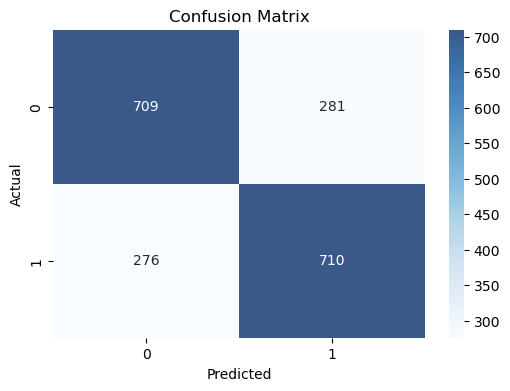

In [125]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", alpha = 0.8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<p>
<b> Findings: </b>The confusion matrix shows that the model correctly predicted <b>709</b> blue team losses and <b>710</b> blue team wins. However, it misclassified <b>281</b> losses as wins (false positives) and <b>276</b> wins as losses (false negatives). The relatively balanced number of correct and incorrect predictions across both classes indicates that the model performs consistently for wins and losses, resulting in an overall accuracy of approximately <b>72%</b>.
</p>


<br>
<b> Visualization of feature importance</b><p></p>
The influence of each feature on the model’s predictions can also be visualized. The magnitude of each coefficient represents the weight the model gives to that feature. The sign indicates whether a feature makes the model more or less likely to predict a blue team win.

/var/folders/z7/gxlr1b496w31kr8_ng519vzm0000gn/T/ipykernel_76035/1141189619.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=coef_df, x="Coefficient", y="Feature", palette='coolwarm')


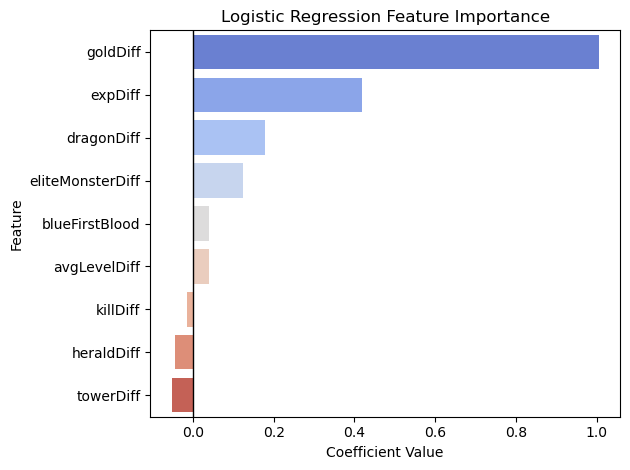

In [126]:
coeffs = model.coef_[0]
features = X.columns

coef_df = pd.DataFrame({"Feature": features, "Coefficient": coeffs}).sort_values(by="Coefficient", ascending=False)
sb.barplot(data=coef_df, x="Coefficient", y="Feature", palette='coolwarm')

plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

<p>
<b> Findings: </b> The 3 leading features that drove the model's decision-making were differences in Gold, Exp, and Dragons. Contrary to belief, the differences in kills were a near-negligible feature. This may illustrate how the model perceives that raw kills matter very little compared to the gold those kills provide. As previously mentioned, the rare nature of obtaining a tower or herald in the early game may be reflected within this coefficient dataframe.
</p>


<br>
<h2>6. Limitations and Future Work</h2>
<hr>


<h3>Limitations and Future Work</h3>

<p>
Due to the volatile and dynamic nature of <em>League of Legends</em>, predicting match outcomes from early-game statistics presents inherent challenges. While several features were indicative of victory, the state of a match can shift significantly as it progresses into later stages (15, 20, or 30+ minutes).
</p>

<p><strong>Limitations:</strong></p>
<ul>
  <li>
    <strong>Lack of champion-specific information:</strong>
    Different champions interact uniquely with one another, and some compositions are designed to scale into the late game while others dominate early. Without accounting for champion matchups or team composition, the model cannot capture these strategic dynamics.
  </li>
  <li>
    <strong>Rank-specific data bias:</strong>
    The dataset consists primarily of Diamond-ranked matches, where players generally demonstrate consistent mechanics and decision-making. Model performance may differ in lower ranks with higher variance or in professional play where macro-strategy is emphasized.
  </li>
  <li>
    <strong>Temporal limitations of early-game data:</strong>
    All features are derived from the first 10 minutes of gameplay. While early advantages are informative, they do not fully represent mid- and late-game decision-making, team fights, or objective control.
  </li>
  <li>
    <strong>Limited representation of macro-strategy:</strong>
    Concepts such as map pressure, vision effectiveness, rotations, and objective trading are difficult to quantify and are not directly captured by the engineered features.
  </li>
  <li>
    <strong>Model simplicity:</strong>
    Logistic regression provides interpretability but may fail to capture complex nonlinear relationships present in competitive gameplay.
  </li>
  <li>
    <strong>Binary outcome framing:</strong>
    The model predicts win or loss without accounting for confidence, momentum shifts, or comeback potential.
  </li>
</ul>

<p><strong>Future Work:</strong></p>
<ul>
  <li>Incorporate champion-level features such as champion identities, roles, and scaling characteristics.</li>
  <li>Extend feature engineering to include mid- and late-game statistics.</li>
  <li>Evaluate model performance across multiple ranks and professional-level datasets.</li>
  <li>Experiment with more expressive nonlinear models (e.g., Random Forests, Gradient Boosting, Neural Networks).</li>
  <li>Explore time-series or sequence-based models to capture evolving game states.</li>
</ul>


<br>
<h2>7. Conclusion</h2>
<hr>


<p>
Throughout this project, early-game League of Legends match data (first 10 minutes) was analyzed to identify which factors are most strongly associated with victory. Using these insights, a logistic regression model was built to predict blue-side match outcomes based on early-game advantages.
</p>

<h3>Key Findings from Exploratory Data Analysis (EDA)</h3>
<ul>
  <li>Blue team victories were consistently associated with positive differences in gold, experience, kills, and average champion level.</li>
  <li>Vision-related metrics, such as wards placed and wards destroyed, showed little to no direct impact on match outcomes when considered in isolation.</li>
  <li>Early objective control was important overall; however, dragon advantages exhibited a stronger and more consistent relationship with winning compared to Heralds or early towers.</li>
  <li>Early-game momentum, reflected through economic and combat advantages, was strongly correlated with a higher likelihood of victory.</li>
</ul>

<h3>Model Performance Summary</h3>
<ul>
  <li>A logistic regression model was selected due to the binary nature of the prediction task (win vs. loss) and its interpretability.</li>
  <li>The model achieved an accuracy of approximately 72% when evaluated on a held-out test set comprising 20% of the data.</li>
  <li>The model correctly classified 709 blue team losses and 710 blue team wins, indicating balanced performance across both classes.</li>
</ul>

<h3>Model Behavior and Interpretation</h3>
<ul>
  <li>Gold difference was assigned high importance by the model, reflecting its role as the primary resource for itemization and champion power progression.</li>
  <li>Experience difference also emerged as a key predictive feature, reinforcing the importance of early level advantages.</li>
  <li>Overall, the model emphasized early economic control as the strongest indicator of eventual match outcome.</li>
</ul>

<h3>Final Takeaway</h3>
<p>
While early-game advantages provide meaningful predictive signals for match outcomes, League of Legends games remain highly dynamic and context-dependent. These results highlight both the value and the limitations of using early-game data alone to model and predict victory.
</p>
